# Disease Analysis
Analyze data from the National Notifiable Diseases Surveillance System on [deaths by pneumonia and influenza](https://www.healthdata.gov/dataset/nndss-table-ii-invasive-pneumococcal-diseases-all-ages) in 122 cities.

In [1]:
import numpy as np
from scipy import stats
import cntk as C

In [2]:
dataPath = "source.csv"
data = np.genfromtxt(dataPath, delimiter = ",", dtype = str)

In [3]:
num_features = 2 #Year and winter
num_classes = 1  #Number of deaths

deaths = data[1:, 6]
non_blanks = []
for i in range(len(deaths)):
    if deaths[i] != "":
        non_blanks.append(i)        
deaths = deaths[non_blanks].astype(np.float32)

years = stats.zscore( (data[1:, 0])[non_blanks].astype(np.float32))

winter = np.asarray( [1.0 if (week < 7 or 47 < week) else 0.0 for week in data[1:, 1].astype(int)], dtype = np.float32 )
winter = winter[non_blanks]

features = np.column_stack((years, winter))
labels = deaths.reshape((len(deaths), num_classes))

In [4]:
np.random.seed(0)
def shuffle_arrays(*arrays):
    rand_state = np.random.get_state()
    for array in arrays:
        np.random.set_state(rand_state)
        np.random.shuffle(array)

shuffle_arrays(features, labels)

In [5]:
parm_dict = {}
def linear_layer(input_var, num_output_classes):
    weights = C.parameter(shape = (input_var.shape[0], num_output_classes))
    biases = C.parameter(shape = (num_output_classes))
    return C.times(input_var, weights) + biases

In [6]:
#Model variables
input_var = C.input_variable(num_features, np.float32)
label = C.input_variable((num_classes), np.float32)
z = linear_layer(input_var, num_classes)
loss = C.squared_error(z, label)
eval_error = C.squared_error(z, label)

In [7]:
num_samples = len(years)
training_size = num_samples * 2 // 3;
training_minibatch_size = 25
num_training_minibatches = training_size // training_minibatch_size
learning_rate = 0.5

lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, eval_error), [learner])

In [8]:
def moving_average(loss_list):
    averages = np.cumsum(np.asarray(loss_list))
    for i in range(len(averages)):
        averages[i] = averages[i] / (i + 1)
    return averages

def print_progress(trainer, mb_num, frequency, display = True):
    loss = "NA"
    if mb_num % frequency == 0:
        loss = trainer.previous_minibatch_loss_average
        if display:
            print("Minibatch {0:04n}: Average Loss = {1:.4f}".format(mb_num, loss))
    return mb_num, loss

In [9]:
from collections import defaultdict

progress_output_freq = 500
training_plotdata = defaultdict(list)

training_features = features[:training_size]
training_labels = labels[:training_size]

for i in range(num_training_minibatches):
    start_index = i * training_minibatch_size
    end_index = start_index + training_minibatch_size
    feature_batch = training_features[start_index : end_index]
    label_batch = training_labels[start_index : end_index]
    
    trainer.train_minibatch({input_var : feature_batch, label : label_batch})
    
    mb_num, loss = print_progress(trainer, i, progress_output_freq)
    if loss != "NA":
        training_plotdata["Batch Number"].append(mb_num)
        training_plotdata["Loss"].append(loss)

Minibatch 0.000000: Average Loss = 284.7200
Minibatch 500.000000: Average Loss = 50.8294
Minibatch 1000.000000: Average Loss = 39.2316
Minibatch 1500.000000: Average Loss = 12.0060
Minibatch 2000.000000: Average Loss = 121.9783
Minibatch 2500.000000: Average Loss = 37.7002
Minibatch 3000.000000: Average Loss = 44.9993
Minibatch 3500.000000: Average Loss = 46.6306
Minibatch 4000.000000: Average Loss = 52.5958
Minibatch 4500.000000: Average Loss = 84.0237
Minibatch 5000.000000: Average Loss = 34.1844
Minibatch 5500.000000: Average Loss = 16.7190
Minibatch 6000.000000: Average Loss = 20.1105
Minibatch 6500.000000: Average Loss = 12.4809
Minibatch 7000.000000: Average Loss = 37.5271
Minibatch 7500.000000: Average Loss = 150.1719
Minibatch 8000.000000: Average Loss = 26.9058
Minibatch 8500.000000: Average Loss = 144.5658
Minibatch 9000.000000: Average Loss = 24.1921


In [10]:
test_minibatch_size = training_minibatch_size
testing_features = features[training_size:]
testing_labels = labels[training_size:]
num_testing_minibatches = (num_samples - training_size) // test_minibatch_size

testing_plotdata = defaultdict(list)

for i in range(num_testing_minibatches):
    start_index = i * test_minibatch_size
    end_index = start_index + test_minibatch_size
    feature_batch = testing_features[start_index : end_index]
    label_batch = testing_labels[start_index : end_index]
    
    eval_error = trainer.test_minibatch({input_var : feature_batch, label : label_batch})
    
    if eval_error != "NA":
        testing_plotdata["Batch Number"].append(i)
        testing_plotdata["Loss"].append(eval_error)

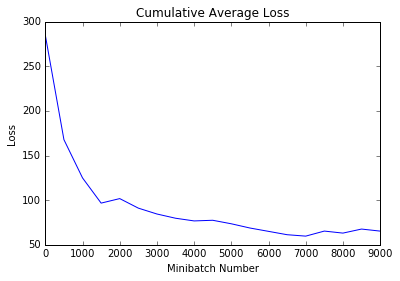

Average Training Loss = 65.35


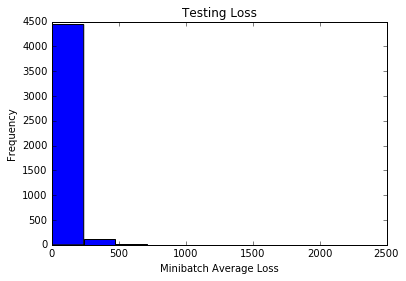

Average Testing Loss = 56.05


In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

training_plotdata["Average Loss"] = moving_average(training_plotdata["Loss"])
testing_plotdata["Average Loss"] = moving_average(testing_plotdata["Loss"])

plt.plot(training_plotdata["Batch Number"], training_plotdata["Average Loss"])
plt.title("Cumulative Average Loss")
plt.xlabel("Minibatch Number")
plt.ylabel("Loss")
plt.show()

print("Average Training Loss = {0:.2f}".format(training_plotdata["Average Loss"][-1]))


plt.hist(testing_plotdata["Loss"])
plt.title("Testing Loss")
plt.xlabel("Minibatch Average Loss")
plt.ylabel("Frequency")
plt.show()

print("Average Testing Loss = {0:.2f}".format(testing_plotdata["Average Loss"][-1]))

## Sample Evaluation

In [35]:
eval_size = 10
eval_features = features[-eval_size:]
eval_labels = labels[-eval_size:].reshape(eval_size)

predictions = z.eval({input_var : eval_features, label : eval_labels}).reshape(eval_size)

#print("Deaths Predicted: ", np.round(predictions).astype(int))
#print("   Actual Deaths: ", eval_labels.astype(int))

def print_array(array, size):
    print("[", end = "")
    print("{0:02n}".format(array[0]), end = "")
    for i in range(1, size):
        print(" {0:02n}".format(array[i]), end = "")
    print("]")
    
print("Deaths Predicted: ", end = "")
print_array(np.round(predictions).astype(int), eval_size)

print("   Actual Deaths: ", end = "")
print_array(eval_labels.astype(int), eval_size)


Deaths Predicted: [04 03 06 06 05 05 06 06 03 05]
   Actual Deaths: [00 03 12 06 18 01 03 02 08 00]
